# Autocodificadores

Fazer um jupyter notebook com autocodificador, a exemplo do exemplo mostrado em aula usando o Keras:

- https://t-adessowiki.fee.unicamp.br/user/aluno/notebooks/ia368z_2s2017/ia368z/deliver-keras/DenseAutoencoder.ipynb

Com as seguintes modificações:

- Utilizar o PyTorch
- Se possível, utilizar um autocodificador convolucional, porém não é imperativo
- Uma vez que o autocodificador seja treinado e o espaço bidimensional seja mostrado dos códigos dos dígitos da base de dados NMIST, gerar novas imagens:
  - mostrar algumas imagens em pontos quaisquer neste espaço bidimensional
  - dados dois pontos neste espaço, mostrar várias imagens, começando no ponto 1 e caminhando numa reta que une os dois pontos, gerar imagens associadas a pontos igualmente espaçados nessa reta, até chegar ao segundo ponto. É se esperar que os números gerados sejam interpolados entre eles.

In [1]:
import torch
import torchvision
import numpy as np
from torch.autograd import Variable

from PIL import Image
from IPython import display
from time import time


## Carregamento do MNIST dataset (já está no disco)

A base de dados MNIST está disponível em: http://yann.lecun.com/exdb/mnist/
Consiste de 60 mil amostras de treinamento e 10 mil amostras de teste. Cada amostra é uma pequena imagem em níveis de cinza de tamanho 28x28 pixels com valores entre 0 e 255.

A base já está carregada e disponível em /data/datasets:

In [2]:
#data_train = torchvision.datasets.MNIST('mnist/', train=True)
#data_test  = torchvision.datasets.MNIST('mnist/', train=False)

data_train = torchvision.datasets.MNIST('./data', train=True, download=True, transform=torchvision.transforms.Compose([
    torchvision.transforms.ToTensor(), torchvision.transforms.Normalize((0.5, 0.5, 0.5), (0.5, 0.5, 0.5)),
]), )

data_test = torchvision.datasets.MNIST('./data', train=False, download=True, transform=torchvision.transforms.Compose([
    torchvision.transforms.ToTensor(), torchvision.transforms.Normalize((0.5, 0.5, 0.5), (0.5, 0.5, 0.5)),
]), )

In [3]:
len(data_train), len(data_test)

(60000, 10000)

In [4]:
data_train.train_data.size(), data_test.test_data.size()

(torch.Size([60000, 28, 28]), torch.Size([10000, 28, 28]))

## Treinando com pouquíssimos dados

In [5]:
if False:
    n_train_samples = 1000
    n_test_samples = 500
    data_train.train_data = data_train.train_data[:n_train_samples]
    data_test.test_data   = data_test.test_data[:n_test_samples]

In [6]:
data_train.train_data.size(), data_test.test_data.size()

(torch.Size([60000, 28, 28]), torch.Size([10000, 28, 28]))

## Cria DataLoader

In [7]:
train_loader = torch.utils.data.DataLoader(data_train,
                                          batch_size=64,
                                          shuffle=True,
                                          num_workers=1)

test_loader = torch.utils.data.DataLoader(data_test,
                                         batch_size=10000,
                                         shuffle=False,
                                         num_workers=2)

## Visualizando algumas amostras

In [8]:
to_pil = torchvision.transforms.ToPILImage()

for k in range(5):
    x, y = data_test[k]
    display.display(to_pil(x))
    print('label=',y)

label= 7


label= 2


label= 1


label= 0


label= 4


## Definição das classes que representam as redes

In [9]:
import torch.nn.functional as F

# classe do AutoEncoder (Encoder + Decoder)
class AutoEncoder(torch.nn.Module):
    def __init__(self, encoder, decoder):
        super(AutoEncoder, self).__init__()
        
        self.encoder = encoder
        self.decoder = decoder
        
    def forward(self, x):
        x = self.encoder(x)
        x = self.decoder(x)
        return x

# classe do Encoder
class Encoder(torch.nn.Module):
    def __init__(self):
        super(Encoder, self).__init__()
        
        self.encode_conv1 = torch.nn.Conv2d(1, 16, 3, stride=3, padding=1)
        self.encode_pool1 = torch.nn.MaxPool2d(2, stride=2)
        self.encode_conv2 = torch.nn.Conv2d(16, 8, 3, stride=2, padding=1)
        self.encode_pool2 = torch.nn.MaxPool2d(2, stride=1)

    def forward(self, x):
        x = F.relu(self.encode_conv1(x))
        x = self.encode_pool1(x)
        x = F.relu(self.encode_conv2(x))
        x = self.encode_pool2(x)
        return x

# classe do Decoder
class Decoder(torch.nn.Module):
    def __init__(self):
        super(Decoder, self).__init__()
        
        self.decode_conv1 = torch.nn.ConvTranspose2d(8, 16, 3, stride=2)
        self.decode_conv2 = torch.nn.ConvTranspose2d(16, 8, 5, stride=3, padding=1)
        self.decode_conv3 = torch.nn.ConvTranspose2d(8, 1, 2, stride=2, padding=1)
        
    def forward(self, x):
        x = F.relu(self.decode_conv1(x))
        x = F.relu(self.decode_conv2(x))
        x = F.tanh(self.decode_conv3(x))
        return x

In [10]:
autoencoder = AutoEncoder(Encoder(), Decoder())
print(autoencoder)

AutoEncoder (
  (encoder): Encoder (
    (encode_conv1): Conv2d(1, 16, kernel_size=(3, 3), stride=(3, 3), padding=(1, 1))
    (encode_pool1): MaxPool2d (size=(2, 2), stride=(2, 2), dilation=(1, 1))
    (encode_conv2): Conv2d(16, 8, kernel_size=(3, 3), stride=(2, 2), padding=(1, 1))
    (encode_pool2): MaxPool2d (size=(2, 2), stride=(1, 1), dilation=(1, 1))
  )
  (decoder): Decoder (
    (decode_conv1): ConvTranspose2d(8, 16, kernel_size=(3, 3), stride=(2, 2))
    (decode_conv2): ConvTranspose2d(16, 8, kernel_size=(5, 5), stride=(3, 3), padding=(1, 1))
    (decode_conv3): ConvTranspose2d(8, 1, kernel_size=(2, 2), stride=(2, 2), padding=(1, 1))
  )
)


## Definição da função de predição

In [11]:
def prediction(loader, model, loss_fn):
    for data in loader:
        images, labels = data
        
        # forward pass
        outputs = model(Variable(images))

        # loss
        loss = loss_fn(outputs, Variable(images))
    return (loss.data[0])

## Treinamento da rede

In [16]:
import copy

epochs = 100
last_epoch = epochs - 1
patience = 10
patience_count = 0
best_model = []
best_val_loss = 999
loss_fn = torch.nn.MSELoss()
optimizer = torch.optim.Adam(autoencoder.parameters(),
                             lr=1e-3,
                             weight_decay=1e-5)

# histórico de acurácia e perda
train_loss = np.empty(epochs)
val_loss = np.empty(epochs)
    
for t in range(epochs):
    start_time = time()
    for i, data in enumerate(train_loader):
        # pega entradas
        inputs, labels = data
        inputs, labels = Variable(inputs), Variable(labels.type(torch.LongTensor))

        # forward pass
        predict = autoencoder(inputs)

        # loss
        loss = loss_fn(predict, inputs)

        # zera gradiente
        optimizer.zero_grad()
            
        # calcula novos gradientes
        loss.backward()

        # atualiza pesos
        optimizer.step()

    elapsed_time = time() - start_time
    # perda no conjunto de treinamento
    train_loss[t] = prediction(train_loader, autoencoder, loss_fn)
    # perda no conjunto de teste
    val_loss[t] = prediction(test_loader, autoencoder, loss_fn)
    # imprime dados do treinamento
    print('Epoch:', t, '-',round(elapsed_time,0),'s',
          '\t train loss:', round(train_loss[t],5), 
          '\t val loss:', round(val_loss[t],5))

    # verifica melhora do modelo
    if(best_val_loss > val_loss[t]):
        patience_count = 0
        best_val_loss = val_loss[t]
        best_model = copy.deepcopy(autoencoder)
        print('Loss improved, saving model from epoch', t)

    # early stop
    if(patience_count > patience):
        print('\nEarly stopping as accuracy did not improve on last', patience, 'epochs!')
        last_epoch = t
        break;

    patience_count += 1

# recupera melhor modelo
autoencoder = best_model
print('Trainning completed!')

Epoch: 0 - 26.0 s 	 train loss: 0.12166 	 val loss: 0.11604
Loss improved, saving model from epoch 0
Epoch: 1 - 26.0 s 	 train loss: 0.13215 	 val loss: 0.11358
Loss improved, saving model from epoch 1
Epoch: 2 - 26.0 s 	 train loss: 0.12005 	 val loss: 0.11272
Loss improved, saving model from epoch 2
Epoch: 3 - 24.0 s 	 train loss: 0.09656 	 val loss: 0.11131
Loss improved, saving model from epoch 3
Epoch: 4 - 26.0 s 	 train loss: 0.11243 	 val loss: 0.11027
Loss improved, saving model from epoch 4
Epoch: 5 - 27.0 s 	 train loss: 0.11034 	 val loss: 0.10936
Loss improved, saving model from epoch 5
Epoch: 6 - 27.0 s 	 train loss: 0.10932 	 val loss: 0.10843
Loss improved, saving model from epoch 6
Epoch: 7 - 25.0 s 	 train loss: 0.13548 	 val loss: 0.10775
Loss improved, saving model from epoch 7
Epoch: 8 - 24.0 s 	 train loss: 0.11484 	 val loss: 0.10707
Loss improved, saving model from epoch 8
Epoch: 9 - 26.0 s 	 train loss: 0.11206 	 val loss: 0.10745
Epoch: 10 - 24.0 s 	 train loss

## Plot da evolução dos erros na função de avaliação

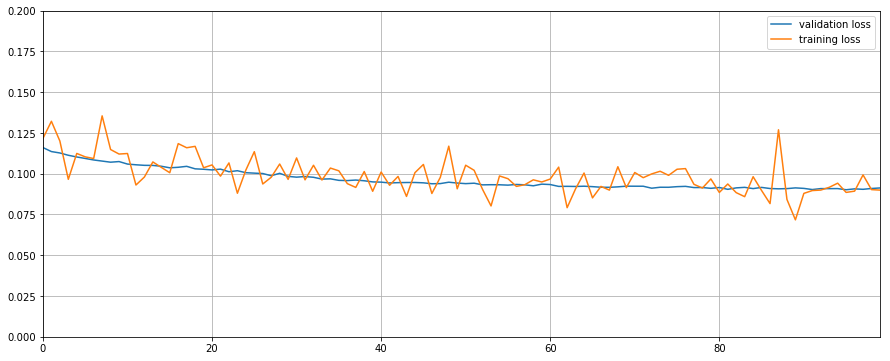

In [18]:
%matplotlib inline
import matplotlib.pyplot as plot

fig = plot.figure(figsize=(15,6))
plot.ylim(0.0, 0.2)
plot.xlim(0, last_epoch)
plot.grid(True)
plot.plot(val_loss, label='validation loss')
plot.plot(train_loss, label='training loss')
plot.legend()

## Mostrando decoding das imagens

In [19]:
for data in test_loader:
    images, labels = data
        
    # forward pass
    data_test_encoded = autoencoder(Variable(images))

In [20]:
n = 10
for i in range(1, n+1):
    x, y = data_test[i]
    display.display(to_pil(x))
    display.display(to_pil(data_test_encoded[i].data))
    print('label=',y)

label= 2


label= 1


label= 0


label= 4


label= 1


label= 4


label= 9


label= 5


label= 9


label= 0
